In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [ ]:
df = pd.read_csv("parking_data.csv")

#calculate available spaces
df['available_spaces'] = df['totalspaces'] - df['vehiclecount']

#convert datetime to epoch/unix time
df['unix'] = pd.to_datetime(df['Datetime']).apply(lambda x: int(x.timestamp()))

In [ ]:
print(df.dtypes)
print(df.head())

_id                  int64
updatetime          object
streamtime          object
Datetime            object
date                object
time                object
weekday              int64
weekday_name        object
vehiclecount         int64
totalspaces          int64
garagecode          object
available_spaces     int64
unix                 int64
dtype: object
   _id               updatetime           streamtime                 Datetime  \
0    1  2014-05-22 09:09:04.145  2014-11-03 16:18:44  2014-05-22 09:09:04.145   
1    2  2014-05-22 09:09:04.145  2014-11-03 16:18:44  2014-05-22 09:09:04.145   
2    3  2014-05-22 09:09:04.145  2014-11-03 16:18:44  2014-05-22 09:09:04.145   
3    4  2014-05-22 09:09:04.145  2014-11-03 16:18:44  2014-05-22 09:09:04.145   
4    5  2014-05-22 09:09:04.145  2014-11-03 16:18:44  2014-05-22 09:09:04.145   

         date             time  weekday weekday_name  vehiclecount  \
0  2014-05-22  09:09:04.145000        3     Thursday             0   
1  2014-

In [ ]:
df.to_csv("parking_data_Predictions.csv")

In [ ]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.available_spaces)

ph = 1200 #20 minutes
ph_index = 20 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 10000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1)
yp_pred = np.zeros(n_s-1)

In [ ]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):  # start out with 2 leading data points
    # Get x and y data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)

    # Initialize weights with decay factor
    weights = np.ones(ns) * mu
    for k in range(ns):
        # Adjust weights according to their timestep away from our prediction
        weights[k] = mu ** k
    weights = np.flip(weights)

    # Perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Store model coefficients and intercepts to compute prediction
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    # Use ph to make the model prediction according to the prediction time
    tp = ts.iloc[i-1] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i-2] = tp
    yp_pred[i-2] = yp

# Create a DataFrame to hold predictions and corresponding timestamps
predictions_df = pd.DataFrame({
    'Timestamp': tp_pred,
    'Predicted_Available_Spaces': yp_pred
})

# Merge predictions DataFrame with the original DataFrame
merged_df = pd.concat([df.iloc[2:n_s], predictions_df], axis=1)

# Export the merged DataFrame to a .csv file
merged_df.to_csv('predictions3.csv', index=False)

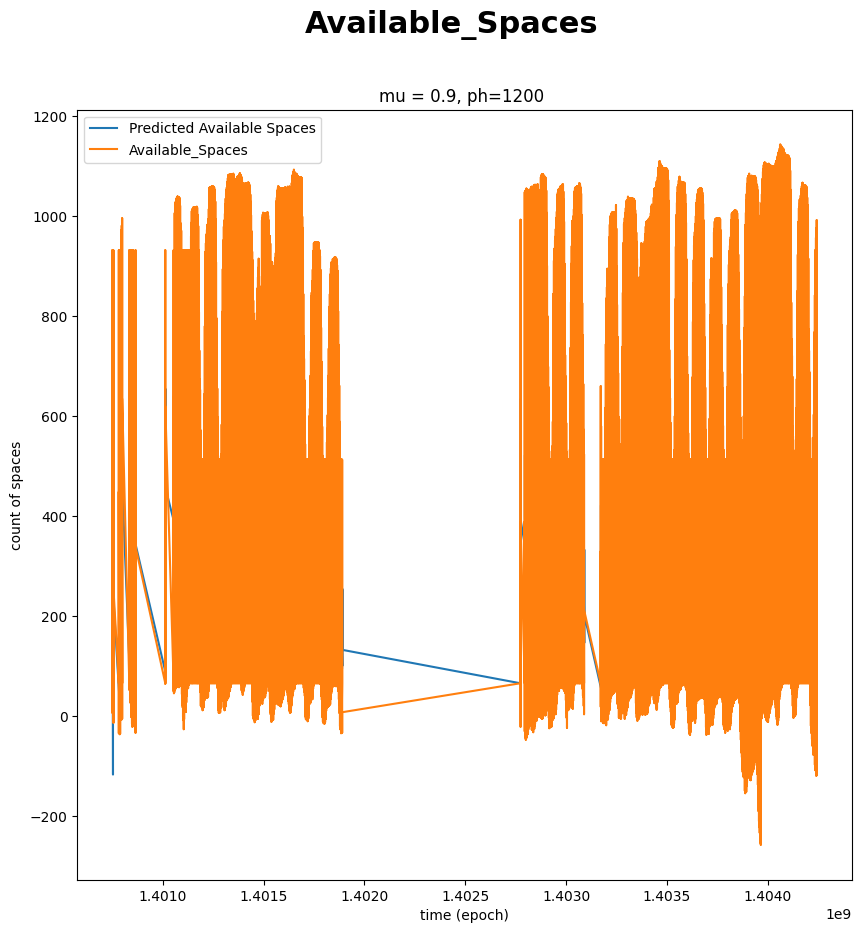

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Available_Spaces', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Available Spaces')
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='Available_Spaces')
ax.set_xlabel('time (epoch)')
ax.set_ylabel('count of spaces')
ax.legend()

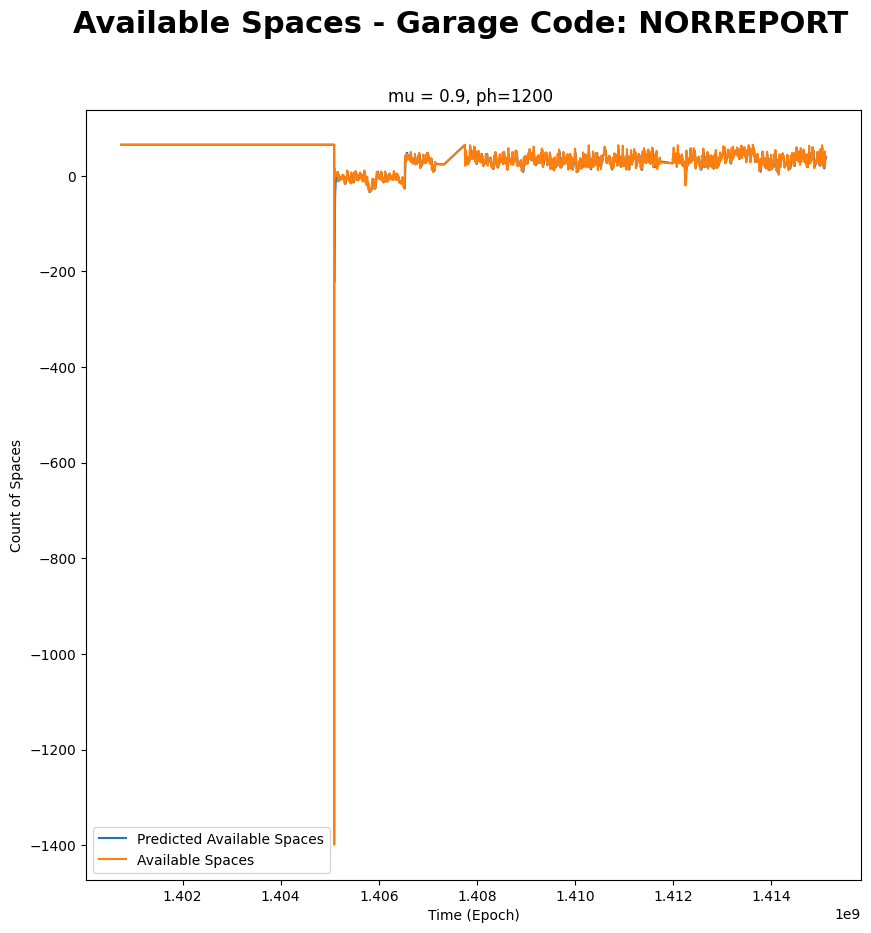

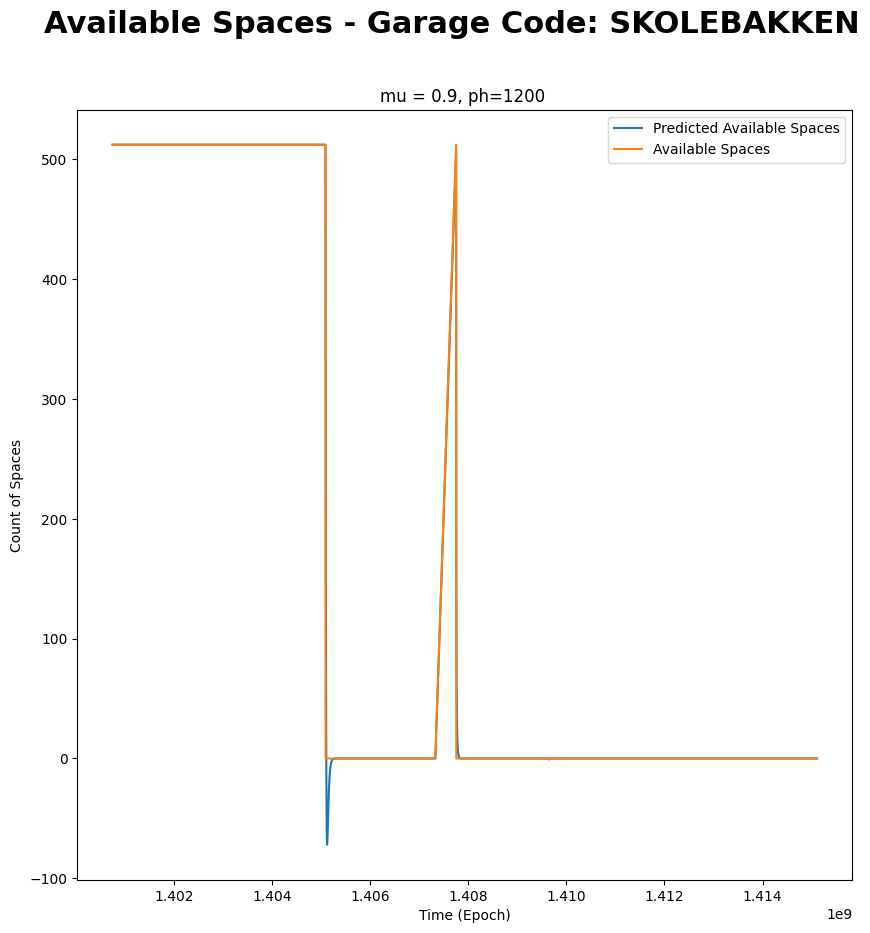

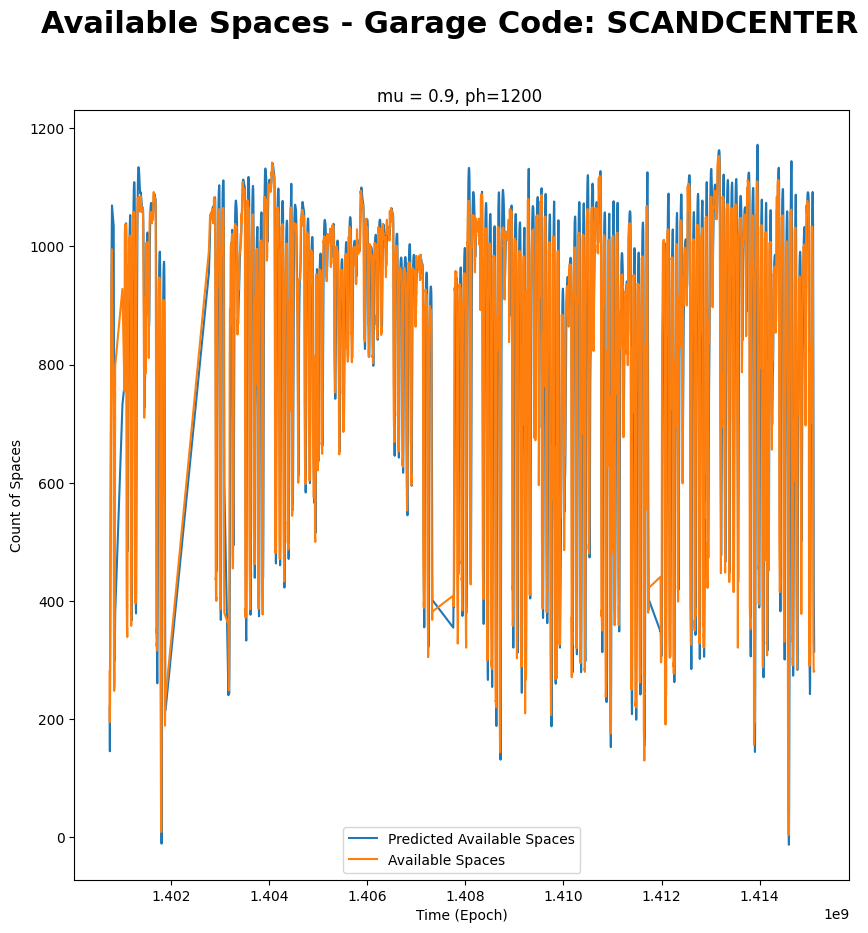

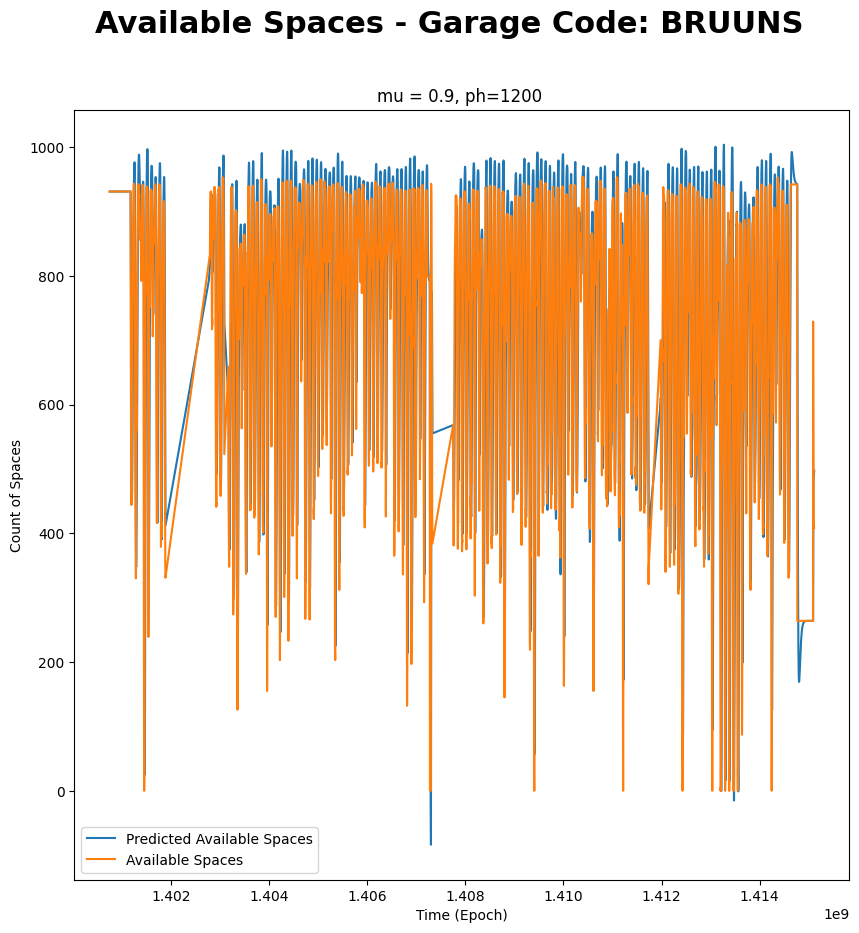

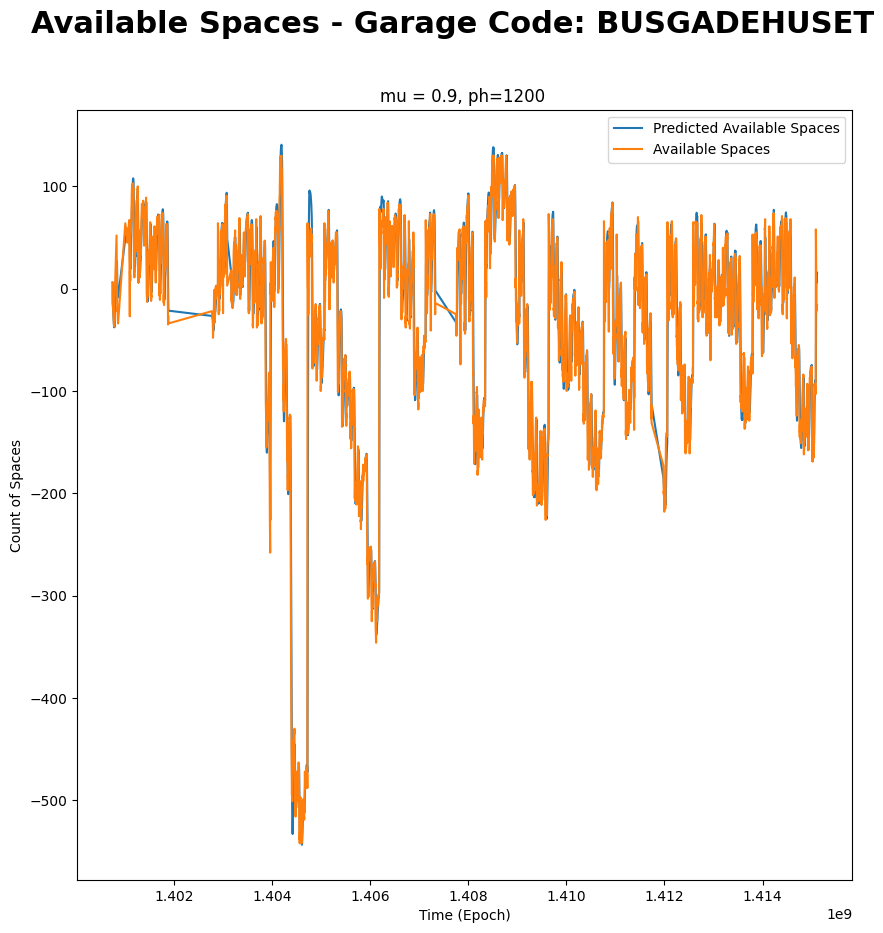

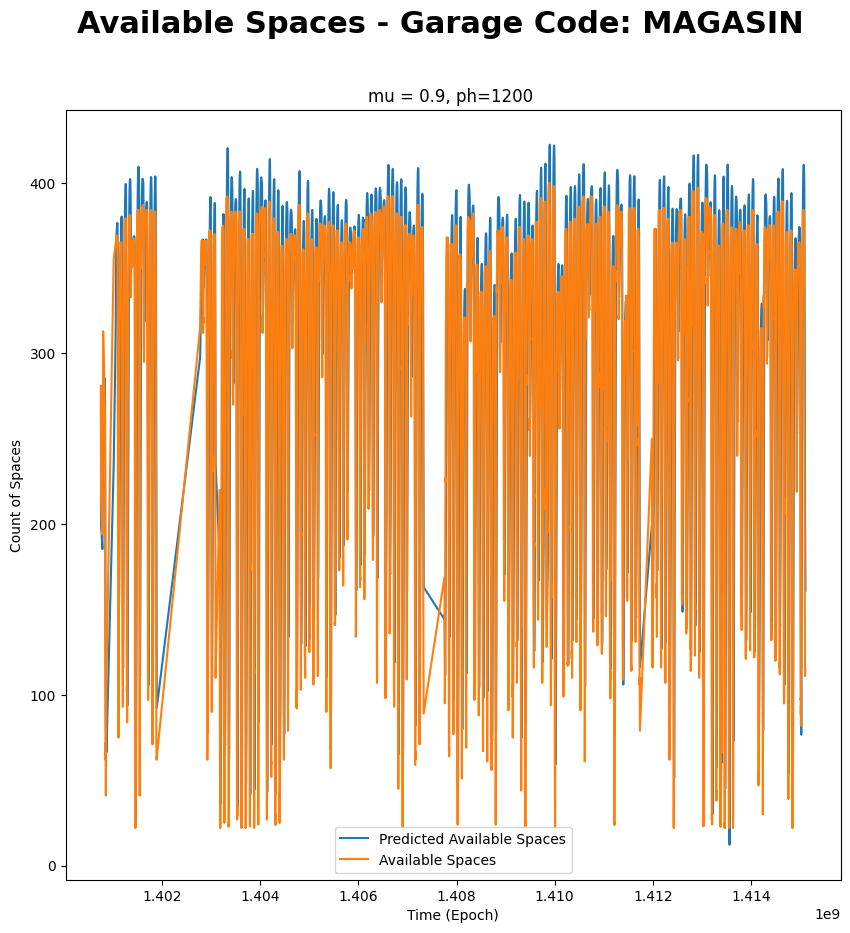

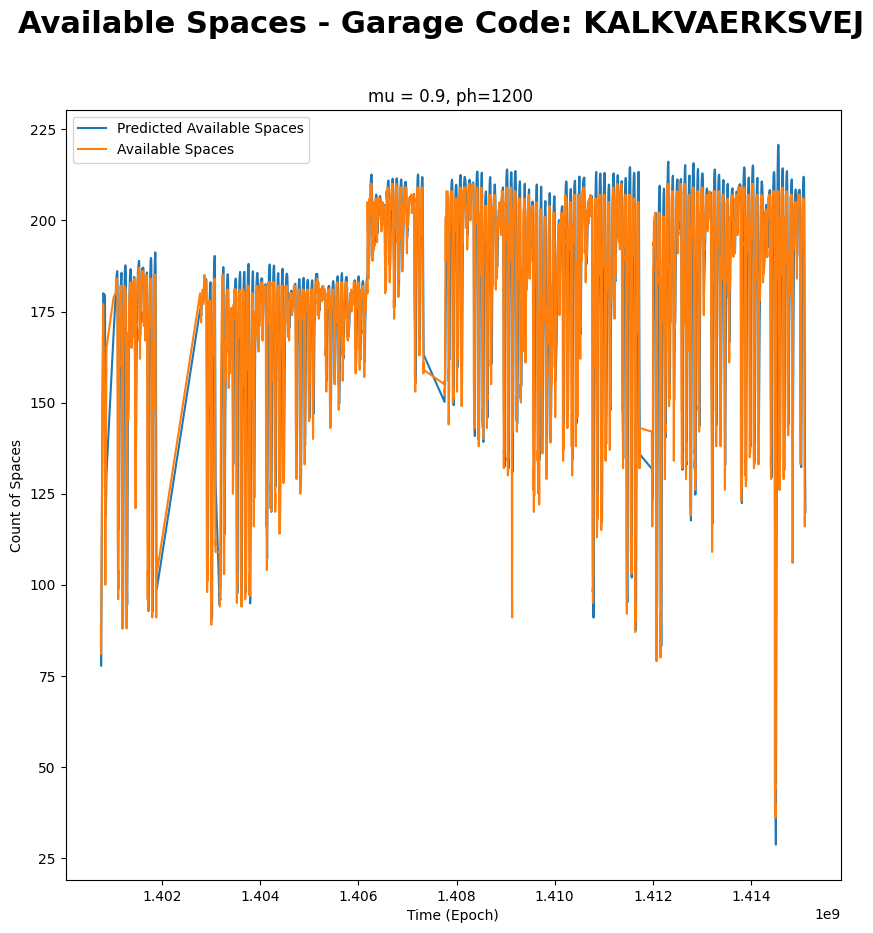

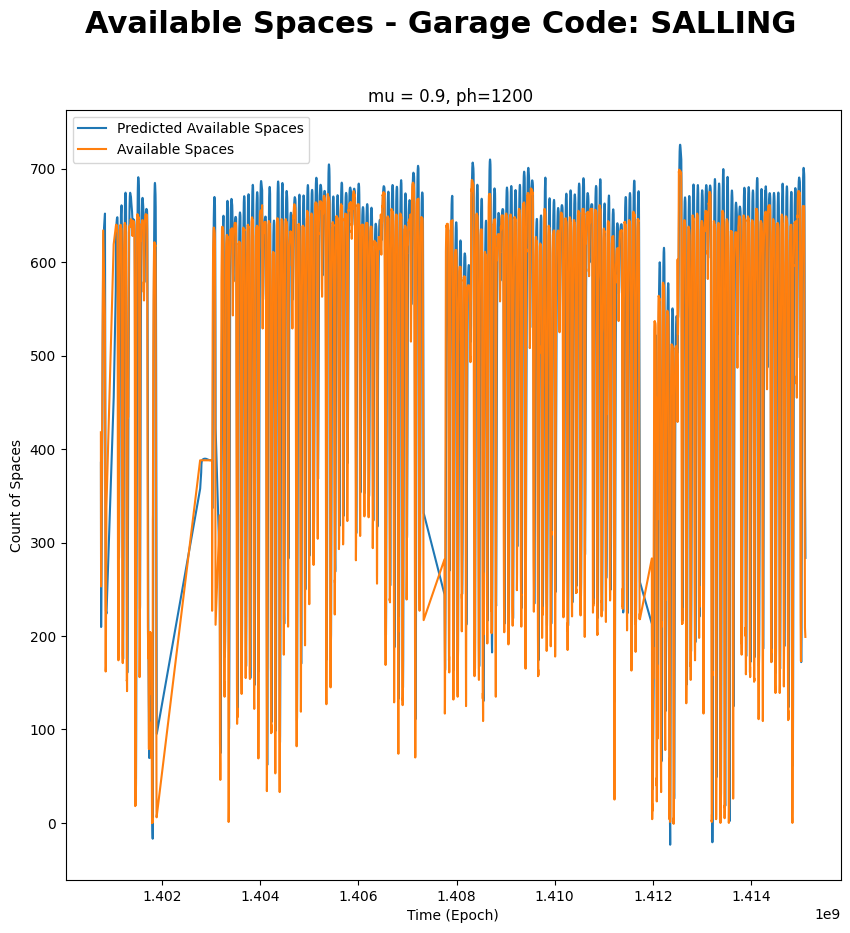

In [ ]:
# Get unique garage codes
garage_codes = df['garagecode'].unique()

# Create a separate plot for each garage code
for garage_code in garage_codes:
    # Filter data for the current garage code
    df_garage = df[df['garagecode'] == garage_code]

    # Perform predictions for the current garage code
    ts_garage = pd.DataFrame(df_garage['unix'])
    ys_garage = pd.DataFrame(df_garage['available_spaces'])

    # Initialize arrays to hold predicted values
    tp_pred_garage = np.zeros(len(df_garage) - 1)
    yp_pred_garage = np.zeros(len(df_garage) - 1)

    for i in range(2, len(df_garage) + 1):  # start out with 2 leading data points
        # Get x and y data "available" for our prediction
        ts_tmp = ts_garage.iloc[:i]
        ys_tmp = ys_garage.iloc[:i]
        ns = len(ys_tmp)

        # Initialize weights with decay factor
        weights = np.ones(ns) * mu
        for k in range(ns):
            # Adjust weights according to their timestep away from our prediction
            weights[k] = mu ** k
        weights = np.flip(weights)

        # Perform linear regression on "available" data using the mu-adjusted weights
        lm_tmp = LinearRegression()
        model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

        # Store model coefficients and intercepts to compute prediction
        m_tmp = model_tmp.coef_[0]
        q_tmp = model_tmp.intercept_

        # Use ph to make the model prediction according to the prediction time
        tp = ts_garage.iloc[i-1] + ph
        yp = m_tmp * tp + q_tmp

        tp_pred_garage[i-2] = tp
        yp_pred_garage[i-2] = yp

    # Plot predictions and actual data for the current garage code
    fig, ax = plt.subplots(figsize=(10, 10))
    fig.suptitle('Available Spaces - Garage Code: {}'.format(garage_code), fontsize=22, fontweight='bold')
    ax.set_title('mu = %g, ph=%g ' % (mu, ph))
    ax.plot(tp_pred_garage, yp_pred_garage, label='Predicted Available Spaces')
    ax.plot(df_garage['unix'].iloc[1:], df_garage['available_spaces'].iloc[1:], label='Available Spaces')
    ax.set_xlabel('Time (Epoch)')
    ax.set_ylabel('Count of Spaces')
    ax.legend()

plt.show()
